In [1]:
# -*- coding: utf8


from scipy.special import gammaln
from scipy.special import psi


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import sys

In [2]:
def init_matplotlib():
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['lines.linewidth'] = 3
    plt.rcParams['font.family'] = 'serif'
    plt.style.use('tableau-colorblind10')
    
    
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [3]:
init_matplotlib()
plt.ion()

In [4]:
def load_centralities(fpath):
    df = pd.read_csv(fpath, index_col=0)
    new_index = []
    if 'allmusic' in fpath:
        am_names = pd.read_csv('../centrality-csvs/allmusic_names.csv',
                               names=['id', 'name'],
                               header=None,
                               index_col=0)
        
        for id_ in df.index:
            new_index.append(am_names.loc[id_][0])
        df.index = pd.Index(new_index)
        df = df.sort_index()
    
    node2id = {}
    id2node = {}
    active_decades = {}
    for artist_id, row in df.iterrows():
        key = artist_id
        while key in node2id:
            key = '{}-repeated'.format(key)
        node2id[key] = len(node2id)
        id2node[node2id[key]] = key
        active_decades[key] = set(map(int, row.dropna().index))
    
    delta = int(df.columns[1]) - int(df.columns[0])
    return df.sort_index(), node2id, id2node, delta, active_decades

In [5]:
def get_rank_positions(decade, node2id, df_centrality):
    n = len(node2id)
    aux = np.zeros(n)
    for node, value in df_centrality[str(decade)].iteritems():
        if type(node) != str and np.isnan(node):
            continue
        if np.isnan(value):
            aux[node2id[node]] = -np.inf
        else:
            aux[node2id[node]] = value
    
    ranks = ss.rankdata(aux, method='max')
    
    values = np.zeros(shape=(2, n), dtype='d')
    values[0] = n - ranks # number above
    values[1] = ranks     # number below
    
    return values.T + 1   # +1 to avoid zeroes

In [6]:
def rank_surprise_detector(observed, prior):
    '''
    Computes the rank based surprise.
    
    Arguments
    ---------
    observed: matrix with the number of nodes with centrality
              values greater then (observed[i][0]) or lower
              then (observed[i][1]) node i.
    prior:    The prior for each node. prior[i][0] is alpha, and
              prior[i][1] is beta. In our paper, we set the prior
              for each such that prior[i][0] / sum(prior[i])
              captures the fraction of other nodes with centrality
              greater than node i.
    
    Both arguments are o shape (n_nodes, 2). Organizing data like
    this make's it easy to compute the posterior = observed + prior.
    
    Returns
    -------
    The posterior and the surprise for each node
    
    References
    ----------
    
    [1]  Penny  WD  (2001):  “KL-Divergences  of  Normal,
         Gamma,  Dirichlet  and  Wishartdensities”.
         University College, London;
         URL: www.fil.ion.ucl.ac.uk/∼wpenny/publications/densities.ps.
    [2]  Kullback-Leibler Divergence Between Two Dirichlet
         (and Beta) Distributions. URL: http://bariskurt.com/
    '''
    posterior = prior + observed
    prior = (prior.T / prior.sum(axis=1)).T
    posterior = (posterior.T / posterior.sum(axis=1)).T
    
    # from here the code is a dkl divergence of dirichlets. adapted and double
    # checked [1] and [2]
    
    d_obs = gammaln(posterior.sum(axis=1)) - np.sum(gammaln(posterior), axis=1)
    d_pri = gammaln(prior.sum(axis=1)) - np.sum(gammaln(prior), axis=1)
    individual_factors = (posterior - prior).T * \
            (psi(posterior).T - psi(posterior.sum(axis=1)))
    surprises = d_obs - d_pri + individual_factors.sum(axis=0)
    
    return prior, posterior, surprises

In [7]:
def hypothesis_past(year, delta, node2id, df):
    prior = get_rank_positions(year - delta, node2id, df)
    # nodes which did not exist 1 delta ago are flat priors.
    invalid = df[str(year - 1 * delta)].isnull().values
    prior[invalid] = 0.25
    
    return prior, invalid

def hypothesis_growth(year, delta, node2id, df):
    
    position_2d_ago = get_rank_positions(year - 2 * delta, node2id, df)
    position_1d_ago = get_rank_positions(year - delta, node2id, df)
    prior = position_1d_ago * (position_1d_ago / position_2d_ago)
    
    # nodes which did not exist 2 deltas ago are flat priors.
    invalid = df[str(year - 2 * delta)].isnull().values
    prior[invalid] = 0.25
    
    return prior, invalid

def hypothesis_flat(year, delta, node2id, df):
    prior = get_rank_positions(year, node2id, df) # just to get the shape
    prior[:] = 0.25
    return prior, np.zeros(len(prior), dtype=bool)

In [8]:
def top_twenty_example():
    df, node2id, id2node, delta, active_decades = \
            load_centralities('../centrality-csvs/allmusic_pageranks.csv')
    for year in map(int, df.columns[2:]):
        obs = get_rank_positions(year, node2id, df)

        hyp = hypothesis_past
        prior_unrmd, invalid = hyp(year, delta, node2id, df)
        prior, posterior, surprises = rank_surprise_detector(obs, prior_unrmd)

        print(year, ' mean surprise ->', surprises.mean())
        top = surprises.argsort()[-20:][::-1]
        for ni in top:
            p = obs[ni][0] / obs[ni].sum()
            beta = ss.beta(a=posterior[ni][0], b=posterior[ni][1])
            print(year-delta, year, id2node[ni],
                  surprises[ni],
                  beta.pdf(p),
                  sep='\t')
        print()

In [9]:
top_twenty_example()

1960  mean surprise -> 1.6906739252045275
1950	1960	The Beatles	1802.888921612292	1.0288933570349144
1950	1960	Lesley Riddle	1320.2817397799076	1.0196699800218472
1950	1960	Bob Dylan	405.5730423219714	0.9987493300499138
1950	1960	The Rolling Stones	274.3799152182481	0.9934198654716234
1950	1960	Ray Charles	269.2267038000464	0.9931565589562068
1950	1960	Bill Monroe	185.1250933687608	0.9876783442179443
1950	1960	Jimi Hendrix	165.5387139433568	0.9858977995794688
1950	1960	The Beach Boys	158.07713058787274	0.9851381136999959
1950	1960	The Byrds	109.4064996305049	0.9784265218383073
1950	1960	The Yardbirds	105.20343710096826	0.977633262273743
1950	1960	The Kinks	96.28563364016424	0.9757753822766956
1950	1960	Otis Redding	81.71513650201177	0.9720806819277784
1950	1960	The Who	80.24746072006978	0.9716510954779309
1950	1960	Cream	74.84968623413181	0.9699586561783672
1950	1960	Bill Evans	67.59515716654937	0.967356014026033
1950	1960	Arthur Alexander	66.57090342831671	0.9669529602716069
1950	1960

In [10]:
def heat_map_surprise_vs_pos():
    df, node2id, id2node, delta, active_decades = \
            load_centralities('../centrality-csvs/allmusic_pageranks.csv')

    decade = int(df.columns[-1])

    prior_unrmd, _ = hypothesis_past(decade, 4 * delta, node2id, df)
    obs = get_rank_positions(decade, node2id, df)
    surprises = rank_surprise_detector(obs, prior_unrmd)[-1]

    prev = 1 - prior_unrmd[:, 0] / prior_unrmd.sum(axis=1)
    new = 1 - obs[:, 0] / obs.sum(axis=1)

    y = new
    x = prev
    z = surprises

    fig, axes = plt.subplots(1, 2, figsize=(15, 4.5))
    
    axes[0].tricontour(x, y, surprises, levels=20, linewidths=0.5, colors='k')
    im = axes[0].tricontourf(x, y, surprises, levels=20, cmap='magma_r')

    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label('Surprise')

    l = np.linspace(max(y.min(), y.min()), min(x.max(), y.max()), 10)
    axes[0].plot(l, l, '--', color='magenta', lw=1)
    axes[0].set_xlabel(r'$1-\hat{\theta}_{i, t-1}$: Frac. inferior on timestamp t-1')
    axes[0].set_ylabel(r'$1-\hat{\theta}_{i, t}$: Frac. inferior on timestamp t')
    despine(axes[0])

    axes[1].tricontour(x, y, np.abs(x-y), levels=20, linewidths=0.5, colors='k')
    im = axes[1].tricontourf(x, y, np.abs(x-y), levels=20, cmap='magma_r')    
    cbar = fig.colorbar(im, ax=axes[1])
    cbar.set_label('Mod Diff.')

    l = np.linspace(max(y.min(), y.min()), min(x.max(), y.max()), 10)
    axes[1].plot(l, l, '--', color='magenta', lw=1)
    axes[1].set_xlabel(r'$1-\hat{\theta}_{i, t-1}$: Frac. inferior on timestamp t-1')
    axes[1].set_ylabel(r'$1-\hat{\theta}_{i, t}$: Frac. inferior on timestamp t')
    despine(axes[1])

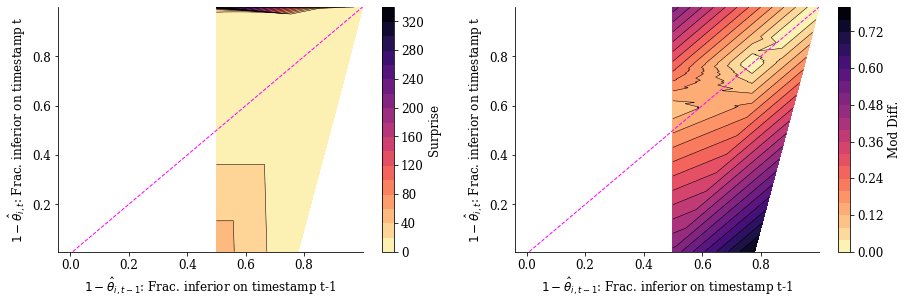

In [11]:
heat_map_surprise_vs_pos()

## Generate CSVs for Paper from Here

From here it's just one big script to generate the csvs used for results in the paper.

In [17]:
df_pagerank, node2id_pagerank, id2node_pagerank, delta, active_decades = \
        load_centralities('../centrality-csvs/whosampled_pageranks_per_year.csv')
df_disrupt, node2id_disrupt, id2node_disrupt, delta, active_decades = \
        load_centralities('../centrality-csvs/whosampled_disruption_per_year.csv')

assert len(df_pagerank) == len(df_disrupt)
assert len(df_pagerank) == len(node2id_pagerank)
assert len(df_pagerank) == len(id2node_pagerank)

for i in range(len(df_pagerank)):
    assert df_pagerank.index[i] == df_disrupt.index[i]

In [18]:
for year in map(int, df_pagerank.columns[2:]):
    rv = {
        'name' : [],
        'year': [],
        'active': [],

        'pagerank_obs_curr_t_nabove': [],
        'pagerank_obs_curr_t_nbelow': [],

        'pagerank_prior_hyp_past_t_alpha': [],
        'pagerank_prior_hyp_past_t_beta': [],
        'pagerank_posterior_hyp_past_t_alpha': [],
        'pagerank_posterior_hyp_past_t_beta': [],
        'pagerank_surprise_hyp_past_t': [],

        'pagerank_prior_hyp_growth_t_alpha': [],
        'pagerank_prior_hyp_growth_t_beta': [],
        'pagerank_posterior_hyp_growth_t_alpha': [],
        'pagerank_posterior_hyp_growth_t_beta': [],
        'pagerank_surprise_hyp_growth_t': [],

        'disrupt_obs_curr_t_nabove': [],
        'disrupt_obs_curr_t_nbelow': [],

        'disrupt_prior_hyp_past_t_alpha': [],
        'disrupt_prior_hyp_past_t_beta': [],
        'disrupt_posterior_hyp_past_t_alpha': [],
        'disrupt_posterior_hyp_past_t_beta': [],
        'disrupt_surprise_hyp_past_t': [],

        'disrupt_prior_hyp_growth_t_alpha': [],
        'disrupt_prior_hyp_growth_t_beta': [],
        'disrupt_posterior_hyp_growth_t_alpha': [],
        'disrupt_posterior_hyp_growth_t_beta': [],
        'disrupt_surprise_hyp_growth_t': []
    }

    obs_pagerank = get_rank_positions(year, node2id_pagerank, df_pagerank)
    
    name_col = []
    year_col = []
    active_col = []
    for i in range(len(obs_pagerank)):
        name_col.append(id2node_pagerank[i])
        year_col.append(year)
        valid = year in active_decades[id2node_pagerank[i]]
        active_col.append(valid)
    
    rv['name'].extend(name_col)
    rv['year'].extend(year_col)
    rv['active'].extend(active_col)
    
    prior_past, posterior_past, surprises_past = \
            rank_surprise_detector(obs_pagerank,
                                   hypothesis_past(year,
                                                   delta,
                                                   node2id_pagerank,
                                                   df_pagerank)[0])
    
    prior_growth, posterior_growth, surprises_growth = \
            rank_surprise_detector(obs_pagerank,
                                   hypothesis_growth(year,
                                                     delta,
                                                     node2id_pagerank,
                                                     df_pagerank)[0])
    
    rv['pagerank_obs_curr_t_nabove'].extend(obs_pagerank[:, 0])
    rv['pagerank_obs_curr_t_nbelow'].extend(obs_pagerank[:, 1])
    
    rv['pagerank_prior_hyp_past_t_alpha'].extend(prior_past[:, 0])
    rv['pagerank_prior_hyp_past_t_beta'].extend(prior_past[:, 1])
    rv['pagerank_posterior_hyp_past_t_alpha'].extend(posterior_past[:, 0])
    rv['pagerank_posterior_hyp_past_t_beta'].extend(posterior_past[:, 1])
    rv['pagerank_surprise_hyp_past_t'].extend(surprises_past)
    
    rv['pagerank_prior_hyp_growth_t_alpha'].extend(prior_growth[:, 0])
    rv['pagerank_prior_hyp_growth_t_beta'].extend(prior_growth[:, 1])
    rv['pagerank_posterior_hyp_growth_t_alpha'].extend(posterior_growth[:, 0])
    rv['pagerank_posterior_hyp_growth_t_beta'].extend(posterior_growth[:, 1])
    rv['pagerank_surprise_hyp_growth_t'].extend(surprises_growth)
    
    
    obs_disrupt = get_rank_positions(year, node2id_disrupt, df_disrupt)
    prior_past, posterior_past, surprises_past = \
            rank_surprise_detector(obs_disrupt,
                                   hypothesis_past(year,
                                                   delta,
                                                   node2id_disrupt,
                                                   df_disrupt)[0])
    
    prior_growth, posterior_growth, surprises_growth = \
            rank_surprise_detector(obs_disrupt,
                                   hypothesis_growth(year,
                                                     delta,
                                                     node2id_disrupt,
                                                     df_disrupt)[0])
    
    rv['disrupt_obs_curr_t_nabove'].extend(obs_disrupt[:, 0])
    rv['disrupt_obs_curr_t_nbelow'].extend(obs_disrupt[:, 1])
    
    rv['disrupt_prior_hyp_past_t_alpha'].extend(prior_past[:, 0])
    rv['disrupt_prior_hyp_past_t_beta'].extend(prior_past[:, 1])
    rv['disrupt_posterior_hyp_past_t_alpha'].extend(posterior_past[:, 0])
    rv['disrupt_posterior_hyp_past_t_beta'].extend(posterior_past[:, 1])
    rv['disrupt_surprise_hyp_past_t'].extend(surprises_past)
    
    rv['disrupt_prior_hyp_growth_t_alpha'].extend(prior_growth[:, 0])
    rv['disrupt_prior_hyp_growth_t_beta'].extend(prior_growth[:, 1])
    rv['disrupt_posterior_hyp_growth_t_alpha'].extend(posterior_growth[:, 0])
    rv['disrupt_posterior_hyp_growth_t_beta'].extend(posterior_growth[:, 1])
    rv['disrupt_surprise_hyp_growth_t'].extend(surprises_growth)
    
    rv = pd.DataFrame(rv)
    rv = rv[rv['active']]
    rv.to_csv('whosampled_surprises-{}.csv'.format(year), index=False)

In [14]:
# rv = pd.DataFrame(rv)
# rv = rv[rv['active']]
# rv.to_csv('allmusic_surprises.csv', index=False)

In [29]:
merge = pd.read_csv('whosampled_surprises-1944.csv')
for year in range(1945, 2021):
    merge = merge.append(pd.read_csv('whosampled_surprises-{}.csv'.format(year)))
merge.head()

1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


,name,year,active,pagerank_obs_curr_t_nabove,pagerank_obs_curr_t_nbelow,pagerank_prior_hyp_past_t_alpha,pagerank_prior_hyp_past_t_beta,pagerank_posterior_hyp_past_t_alpha,pagerank_posterior_hyp_past_t_beta,pagerank_surprise_hyp_past_t,...,disrupt_prior_hyp_past_t_alpha,disrupt_prior_hyp_past_t_beta,disrupt_posterior_hyp_past_t_alpha,disrupt_posterior_hyp_past_t_beta,disrupt_surprise_hyp_past_t,disrupt_prior_hyp_growth_t_alpha,disrupt_prior_hyp_growth_t_beta,disrupt_posterior_hyp_growth_t_alpha,disrupt_posterior_hyp_growth_t_beta,disrupt_surprise_hyp_growth_t
0,Bing Crosby,1944,True,7.0,166072.0,0.5,0.5,0.000044,0.999956,11443.864058,...,0.5,0.5,0.000008,0.999992,66420.147639,0.5,0.5,0.000008,0.999992,66420.147639
0,Bing Crosby,1945,True,9.0,166070.0,0.5,0.5,0.000056,0.999944,8967.619310,...,0.5,0.5,0.000008,0.999992,66420.147639,0.5,0.5,0.000008,0.999992,66420.147639
0,Bing Crosby,1946,True,7.0,166072.0,0.5,0.5,0.000044,0.999956,11443.864058,...,0.5,0.5,0.000008,0.999992,66420.147639,0.5,0.5,0.000008,0.999992,66420.147639
0,Bing Crosby,1947,True,4.0,166075.0,0.5,0.5,0.000026,0.999974,19528.336091,...,0.5,0.5,0.000008,0.999992,66420.147639,0.5,0.5,0.000008,0.999992,66420.147639
1,Frank Sinatra,1947,True,13.0,166066.0,0.5,0.5,0.000080,0.999920,6257.859318,...,0.5,0.5,0.000014,0.999986,36895.490972,0.5,0.5,0.000014,0.999986,36895.490972
